# Grid Search using the whole Human Data

## Read Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

grid_search_results = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\0817_0630_selection_results.csv"

df_grid_search = pd.read_csv(grid_search_results)

params = {
    'init_delta_t':None,
    'init_sigma_position_memory':None,
    'weight_memory_decay':None,
    'spatial_dist_coeff':None,
}

layouts = ['L0', 'L50', 'L100']
metrics = ['steps', 'error']

human_data_steps_list = [1.572, 1.246, 1.032]    # L0, L50, L100
human_data_error_list = [9.311, 4.275, 2.016]    # L0, L50, L100

In [2]:
# # Normalize a list
# def normalize(lst):
#     min_val = min(lst)
#     max_val = max(lst)
#     if min_val == max_val:  # Avoid division by zero
#         return [0.5 for _ in lst]  # Return 0.5 (middle) if all values are same
#     return [(x - min_val) / (max_val - min_val) for x in lst]

# # Compute the sum of squared differences
# def compute_ssd(simulated, human):
#     return sum([(s - h)**2 for s, h in zip(simulated, human)])

# best_params = None
# best_ssd = float('inf')  # initialized to a very large value

# # Iterate over each unique parameter combination
# for param_comb in df_grid_search.drop(['layout', 'steps', 'error'], axis=1).drop_duplicates().iterrows():
#     param_comb = param_comb[1]
#     ssd_steps = 0
#     ssd_error = 0

#     for layout in layouts:
#         filtered_df = df_grid_search[
#             (df_grid_search['init_delta_t'] == param_comb['init_delta_t']) &
#             (df_grid_search['init_sigma_position_memory'] == param_comb['init_sigma_position_memory']) &
#             (df_grid_search['weight_memory_decay'] == param_comb['weight_memory_decay']) &
#             (df_grid_search['spatial_dist_coeff'] == param_comb['spatial_dist_coeff']) &
#             (df_grid_search['layout'] == layout)
#         ]

#         sim_steps = filtered_df['steps'].values[0]
#         sim_error = filtered_df['error'].values[0]

#         ssd_steps += compute_ssd(normalize([sim_steps]), normalize([human_data_steps_list[layouts.index(layout)]]))
#         ssd_error += compute_ssd(normalize([sim_error]), normalize([human_data_error_list[layouts.index(layout)]]))

#     # Sum up the SSDs for steps and error
#     combined_ssd = ssd_steps + ssd_error

#     if combined_ssd < best_ssd:
#         best_ssd = combined_ssd
#         best_params = param_comb

# print("Best parameter set:", best_params)


## Grid Search with the Loss Function of Summed Abs Difference

In [3]:
# Normalize a list
def normalize(lst):
    min_val = min(lst)
    max_val = max(lst)
    if min_val == max_val:  # Avoid division by zero
        return [0.5 for _ in lst]  # Return 0.5 (middle) if all values are same
    return [(x - min_val) / (max_val - min_val) for x in lst]

# Define the cost function
def compute_cost(sim_data, human_data):
    return sum(abs(sim - human) for sim, human in zip(sim_data, human_data))

# Normalize the human data
human_steps_norm = normalize(human_data_steps_list)
human_error_norm = normalize(human_data_error_list)

# Iterate through each unique parameter combination
unique_params = df_grid_search.drop(columns=['layout', 'steps', 'error']).drop_duplicates()

min_cost = float('inf')
best_params = None

for index, row in unique_params.iterrows():
    # Filter the dataframe for the specific parameter combination
    filtered_df = df_grid_search[
        (df_grid_search['init_delta_t'] == row['init_delta_t']) &
        (df_grid_search['init_sigma_position_memory'] == row['init_sigma_position_memory']) &
        (df_grid_search['weight_memory_decay'] == row['weight_memory_decay']) &
        (df_grid_search['spatial_dist_coeff'] == row['spatial_dist_coeff'])
    ]
    
    sim_steps = [filtered_df[filtered_df['layout'] == layout]['steps'].values[0] for layout in layouts]
    sim_error = [filtered_df[filtered_df['layout'] == layout]['error'].values[0] for layout in layouts]
    
    # Normalize the simulated data
    sim_steps_norm = normalize(sim_steps)
    sim_error_norm = normalize(sim_error)
    
    # Compute the cost
    cost_steps = compute_cost(sim_steps_norm, human_steps_norm)
    cost_error = compute_cost(sim_error_norm, human_error_norm)
    total_cost = cost_steps + cost_error

    # Update the best parameters if this cost is lower
    if total_cost < min_cost:
        min_cost = total_cost
        best_params = row

print("Best parameters:", best_params)



Best parameters: init_delta_t                  3.5
init_sigma_position_memory    0.5
weight_memory_decay           0.6
spatial_dist_coeff            2.5
Name: 6975, dtype: float64


In [4]:
print("The min cost is:", min_cost)

The min cost is: 0.008980627614966097


## Handcraft a sim-to-real-mapping-parameter to fit human data and Plot

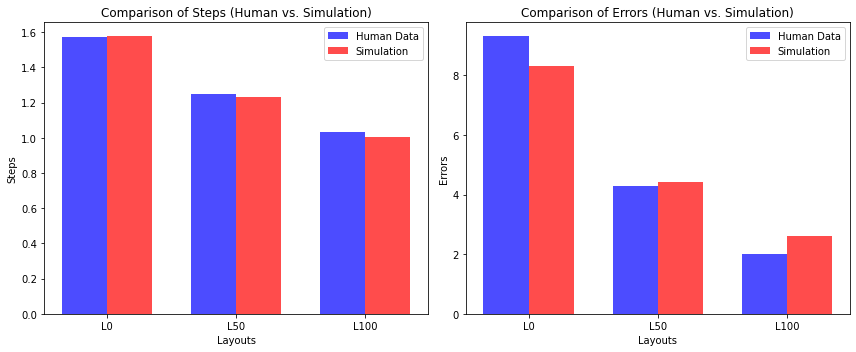

In [13]:
import matplotlib.pyplot as plt

# Using best_params, get the simulation data for steps and errors for the best parameters
filtered_best_params_df = df_grid_search[
    (df_grid_search['init_delta_t'] == best_params['init_delta_t']) &
    (df_grid_search['init_sigma_position_memory'] == best_params['init_sigma_position_memory']) &
    (df_grid_search['weight_memory_decay'] == best_params['weight_memory_decay']) &
    (df_grid_search['spatial_dist_coeff'] == best_params['spatial_dist_coeff'])
]

sim_steps_best = [filtered_best_params_df[filtered_best_params_df['layout'] == layout]['steps'].values[0] for layout in layouts]
sim_error_best = [filtered_best_params_df[filtered_best_params_df['layout'] == layout]['error'].values[0] for layout in layouts]

# Ratios
ratio_steps = 1/6.7
ratio_error = 6.5

# Adjust simulation results by the given ratios
sim_steps_best = [value * ratio_steps for value in sim_steps_best]
sim_error_best = [value * ratio_error for value in sim_error_best]

# Plotting
bar_width = 0.35
indices = np.arange(len(layouts))

plt.figure(figsize=(12, 5))

# For steps
plt.subplot(1, 2, 1)
bar1 = plt.bar(indices, human_data_steps_list, bar_width, label='Human Data', color='b', alpha=0.7)
bar2 = plt.bar(indices + bar_width, sim_steps_best, bar_width, label='Simulation', color='r', alpha=0.7)

plt.xlabel('Layouts')
plt.ylabel('Steps')
plt.title('Comparison of Steps (Human vs. Simulation)')
plt.xticks(indices + bar_width / 2, layouts)  # Positioning on the x axis
plt.legend()

# For errors
plt.subplot(1, 2, 2)
bar1 = plt.bar(indices, human_data_error_list, bar_width, label='Human Data', color='b', alpha=0.7)
bar2 = plt.bar(indices + bar_width, sim_error_best, bar_width, label='Simulation', color='r', alpha=0.7)

plt.xlabel('Layouts')
plt.ylabel('Errors')
plt.title('Comparison of Errors (Human vs. Simulation)')
plt.xticks(indices + bar_width / 2, layouts)  # Positioning on the x axis
plt.legend()

plt.tight_layout()
plt.show()


# Grid Search using 50% Human Data, then Evaluate on other half

## Read Data

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get data source.
simulated_results = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\0817_0630_selection_results.csv"
human_duration_data = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\human data\word selection duration.csv"
human_error_rate_data = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\human data\word selection error rate.csv"

# Read in as dataframe.
df_simulations = pd.read_csv(simulated_results)
human_duration_df = pd.read_csv(human_duration_data)
human_error_rate_df = pd.read_csv(human_error_rate_data)

params = {
    'init_delta_t':None,
    'init_sigma_position_memory':None,
    'weight_memory_decay':None,
    'spatial_dist_coeff':None,
}

layouts = ['L0', 'L50', 'L100']
metrics = ['steps', 'error']

# Get individual-level human data
# human_data_steps_list = [1.572, 1.246, 1.032]    # L0, L50, L100
# human_data_error_list = [9.311, 4.275, 2.016]    # L0, L50, L100
human_duration_data = [human_duration_df[col].tolist() for col in human_duration_df.columns if col != "Participant"]
human_error_data = [human_error_rate_df[col].tolist() for col in human_error_rate_df.columns if col != "Participant"]

In [118]:
human_duration_data

[[1.42, 1.13, 1.13, 4.23, 1.37, 1.81, 1.08, 1.45, 1.59, 1.79, 1.11, 0.75],
 [1.48, 1.94, 0.7, 3.19, 0.64, 1.23, 0.87, 1.11, 1.15, 1.13, 0.95, 0.56],
 [1.38, 1.11, 0.6, 3.36, 0.73, 0.83, 0.85, 0.96, 0.92, 0.78, 0.42, 0.44]]

In [119]:
human_error_data

[[15.46, 2.41, 6.36, 27.27, 3.92, 8.18, 2.0, 11.21, 0.73, 5.26, 10.92, 18.01],
 [2.99, 1.71, 2.96, 11.72, 0.0, 5.29, 1.45, 4.18, 1.98, 3.83, 10.31, 4.88],
 [3.29, 0.0, 0.84, 6.84, 0.91, 0.0, 0.6, 0.18, 0.47, 4.99, 2.12, 3.95]]

## Halve the human data into two parts - training and evaluation

In [120]:
# Normalize a list
def normalize(lst):
    min_val = min(lst)
    max_val = max(lst)
    if min_val == max_val:  # Avoid division by zero
        return [0.5 for _ in lst]  # Return 0.5 (middle) if all values are same
    return [(x - min_val) / (max_val - min_val) for x in lst]

# Define the cost function
def compute_cost(sim_data, human_data):
    return sum(abs(sim - human) for sim, human in zip(sim_data, human_data))

def find_best_params(data, human_duration, human_error):
    unique_params = data.drop(columns=['layout', 'steps', 'error']).drop_duplicates()
    min_cost = float('inf')
    best_params = None

    for index, row in unique_params.iterrows():
        filtered_df = data[
            (data['init_delta_t'] == row['init_delta_t']) &
            (data['init_sigma_position_memory'] == row['init_sigma_position_memory']) &
            (data['weight_memory_decay'] == row['weight_memory_decay']) &
            (data['spatial_dist_coeff'] == row['spatial_dist_coeff'])
        ]
        
        sim_steps = [filtered_df[filtered_df['layout'] == layout]['steps'].values[0] for layout in layouts]
        sim_error = [filtered_df[filtered_df['layout'] == layout]['error'].values[0] for layout in layouts]
        
        cost_steps = compute_cost(normalize(sim_steps), normalize(human_duration))
        cost_error = compute_cost(normalize(sim_error), normalize(human_error))
        
        total_cost = cost_steps + cost_error

        if total_cost < min_cost:
            min_cost = total_cost
            best_params = row
    
    # Given the best parameters and teh dataframe, return the simulated steps (durations) and errors for the three layouts
    sim_steps_best = []
    sim_errors_best = []
    
    # Extract the simulated steps and error for each layout based on best_params
    for layout in layouts:
        filtered_df = data[
            (data['init_delta_t'] == best_params['init_delta_t']) &
            (data['init_sigma_position_memory'] == best_params['init_sigma_position_memory']) &
            (data['weight_memory_decay'] == best_params['weight_memory_decay']) &
            (data['spatial_dist_coeff'] == best_params['spatial_dist_coeff']) &
            (data['layout'] == layout)
        ]
        
        sim_steps_best.append(filtered_df['steps'].values[0])
        sim_errors_best.append(filtered_df['error'].values[0])

    return best_params, min_cost, sim_steps_best, sim_errors_best

In [124]:
%%time

num_iterations = 20
all_costs = []
all_best_params = []

# Lists to store sim-to-real mapping ratios for each iteration
sim_to_real_ratios_duration = []
sim_to_real_ratios_error = []

# Initialize dictionaries for storing results
simulated_durations = {'L0': [], 'L50': [], 'L100': []}
simulated_errors = {'L0': [], 'L50': [], 'L100': []}
human_train_durations = {'L0': [], 'L50': [], 'L100': []}
human_train_errors = {'L0': [], 'L50': [], 'L100': []}
human_test_durations = {'L0': [], 'L50': [], 'L100': []}
human_test_errors = {'L0': [], 'L50': [], 'L100': []}
human_train_durations_details = {'L0': [], 'L50': [], 'L100': []}  # Collect detailed data in each iterations, not aggregated
human_train_errors_details = {'L0': [], 'L50': [], 'L100': []}
human_test_durations_details = {'L0': [], 'L50': [], 'L100': []}
human_test_errors_details = {'L0': [], 'L50': [], 'L100': []}

for i in range(num_iterations):
    # Number of participants
    num_participants = len(human_duration_data[0])

    # Generate list of indices based on participants
    indices = list(range(num_participants))

    # Split indices to ensure consistency
    train_indices, test_indices = train_test_split(indices, test_size=0.5, random_state=i)  
    # using i as the seed for reproducibility

    # Use these indices to split the human data consistently across participants
    def split_data_based_on_indices(data, train_indices, test_indices):
        train_set = [data[i] for i in train_indices]
        test_set = [data[i] for i in test_indices]
        return train_set, test_set

    # Split human duration data
    train_duration = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_duration_data]
    train_duration = list(zip(*train_duration))[0]  # Extracting the training data

    test_duration = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_duration_data]
    test_duration = list(zip(*test_duration))[1]  # Extracting the test data

    # Split human error data
    train_error = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_error_data]
    train_error = list(zip(*train_error))[0]  # Extracting the training data

    test_error = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_error_data]
    test_error = list(zip(*test_error))[1]  # Extracting the test data

    # Compute mean for the training and test sets
    mean_train_duration = [np.mean(data) for data in train_duration]
    mean_train_error = [np.mean(data) for data in train_error]
    mean_test_duration = [np.mean(data) for data in test_duration]
    mean_test_error = [np.mean(data) for data in test_error]

    # Using the function to find the best parameters
    best_params, _, sim_durations, sim_errors = find_best_params(df_simulations, mean_train_duration, mean_train_error)
    all_best_params.append(best_params)
    
    # Get sim to real mapping ratios for duration and error metrics respectively
    # Compute sim-to-real ratio for the current iteration
    sim_to_real_ratio_duration = sum(mean_train_duration) / sum(sim_durations)
    sim_to_real_ratio_error = sum(mean_train_error) / sum(sim_errors)
    
    # Store the computed ratios
    sim_to_real_ratios_duration.append(sim_to_real_ratio_duration)
    sim_to_real_ratios_error.append(sim_to_real_ratio_error)
    
    for label, sd, se, ted, tee, trd, tre in zip(
        ['L0', 'L50', 'L100'], 
        sim_durations, 
        sim_errors, 
        test_duration, 
        test_error, 
        train_duration, 
        train_error,
    ):
        simulated_durations[label].append(sd)
        simulated_errors[label].append(se)
        human_train_durations[label].append(np.mean(trd))
        human_train_errors[label].append(np.mean(tre))
        human_test_durations[label].append(np.mean(ted))
        human_test_errors[label].append(np.mean(tee))
        human_train_durations_details[label].append(trd)
        human_train_errors_details[label].append(tre)
        human_test_durations_details[label].append(ted)
        human_test_errors_details[label].append(tee)

Wall time: 4min 52s


In [148]:
# Copy results for reproducibility
import copy

simulated_durations_copy = copy.deepcopy(simulated_durations)
simulated_errors_copy = copy.deepcopy(simulated_errors)
human_test_durations_copy = copy.deepcopy(human_test_durations)
human_test_errors_copy = copy.deepcopy(human_test_errors)
human_train_durations_copy = copy.deepcopy(human_train_durations)
human_train_errors_copy = copy.deepcopy(human_train_errors)
human_test_durations_details_copy = copy.deepcopy(human_test_durations_details)
human_test_errors_details_copy = copy.deepcopy(human_test_errors_details)
human_train_durations_details_copy = copy.deepcopy(human_train_durations_details)
human_train_errors_details_copy = copy.deepcopy(human_train_errors_details)

## Data evaluation

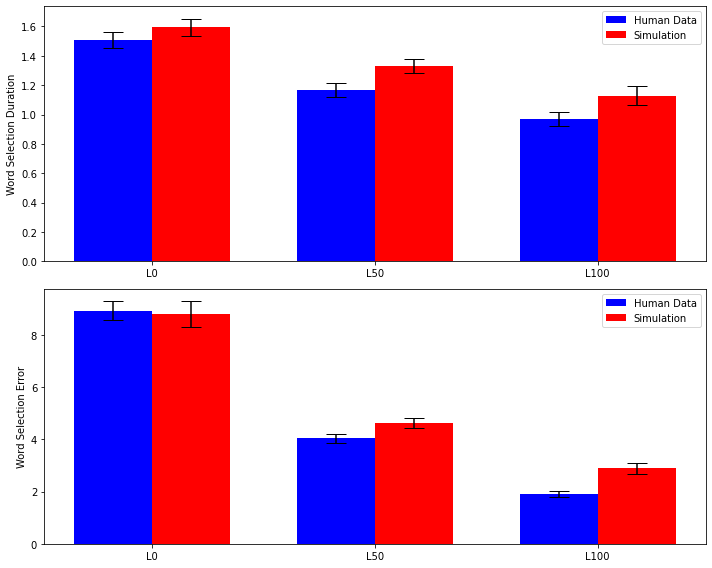

In [149]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['L0', 'L50', 'L100']

# Calculate SEM
def sem(data):
    return np.std(data) / np.sqrt(len(data))

# Using the average results for the test set
mean_human_test_duration = [np.mean(human_test_durations_copy[label]) for label in labels]
sem_human_test_duration = [sem(human_test_durations_copy[label]) for label in labels]

mean_human_test_error = [np.mean(human_test_errors_copy[label]) for label in labels]
sem_human_test_error = [sem(human_test_errors_copy[label]) for label in labels]

# Adjust the simulated data with ratios
for iteration in range(num_iterations):
    for label in labels:
        simulated_durations_copy[label][iteration] *= sim_to_real_ratios_duration[iteration]
        simulated_errors_copy[label][iteration] *= sim_to_real_ratios_error[iteration]

# Now recompute the mean and sem for these adjusted simulated results
mean_simulated_duration = [np.mean(simulated_durations_copy[label]) for label in labels]
sem_simulated_duration = [sem(simulated_durations_copy[label]) for label in labels]

mean_simulated_error = [np.mean(simulated_errors_copy[label]) for label in labels]
sem_simulated_error = [sem(simulated_errors_copy[label]) for label in labels]

# Update the plotting logic
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot for Duration
rects1 = ax[0].bar(x - width/2, mean_human_test_duration, width, label='Human Data', color='blue', yerr=sem_human_test_duration, capsize=10)
rects2 = ax[0].bar(x + width/2, mean_simulated_duration, width, label='Simulation', color='red', yerr=sem_simulated_duration, capsize=10)

# Plot for Error
rects3 = ax[1].bar(x - width/2, mean_human_test_error, width, label='Human Data', color='blue', yerr=sem_human_test_error, capsize=10)
rects4 = ax[1].bar(x + width/2, mean_simulated_error, width, label='Simulation', color='red', yerr=sem_simulated_error, capsize=10)

# Labels, title, and custom x-axis tick labels
ax[0].set_ylabel('Word Selection Duration')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

ax[1].set_ylabel('Word Selection Error')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

fig.tight_layout()
plt.show()


## Get data with only one iteration, like individual showcases

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Read in data
individual_data = r"C:\Users\91584\Desktop\0817_0630_selection_individual_data.csv"

individual_df = pd.read_csv(individual_data)

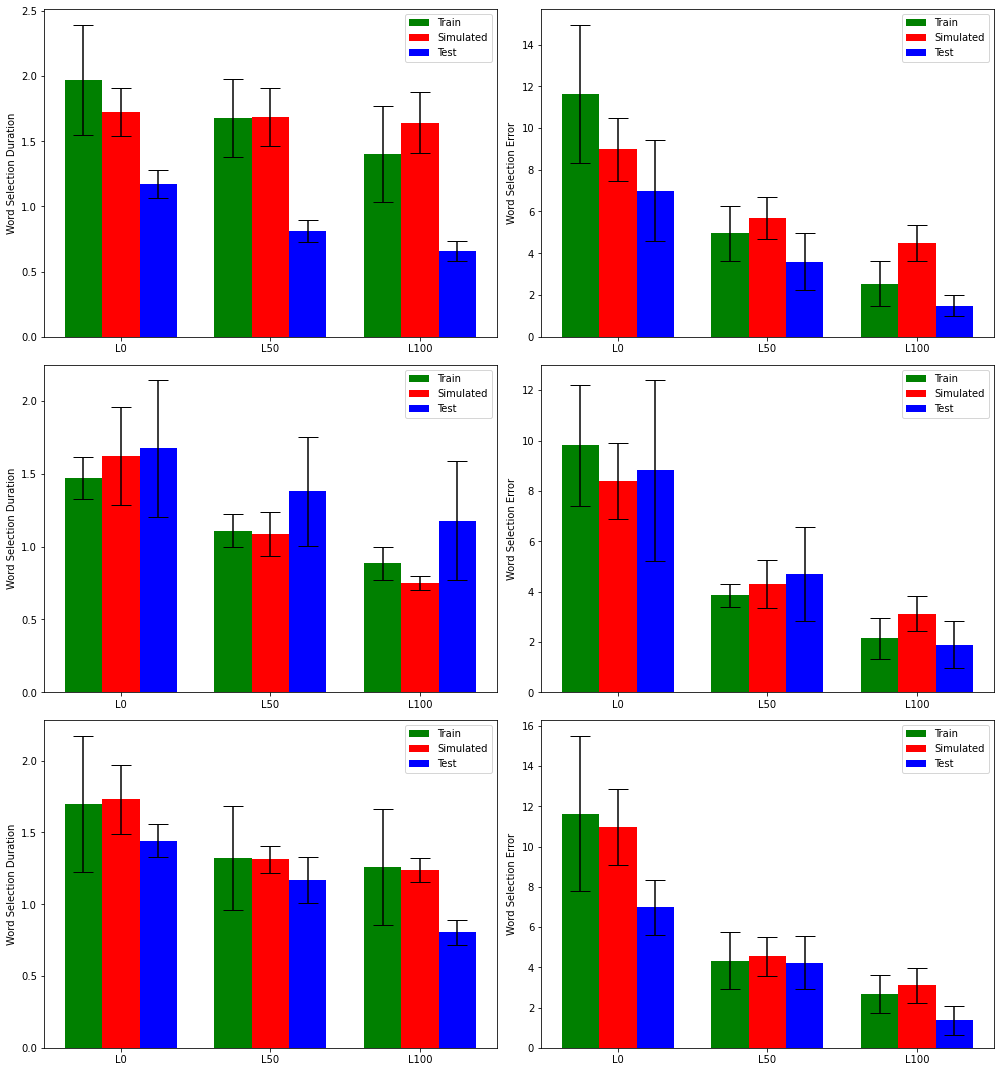

In [147]:
def extract_data(df, params, col_name, layouts):
    # Filter the dataframe based on the provided params
    for key, value in params.items():
        if isinstance(value, float):
            df = df[np.isclose(df[key], value, atol=1e-8)]
        else:
            df = df[df[key] == value]
    
    data = []
    for layout in layouts:
        subset = df[df['layout'] == layout][col_name].tolist()
        data.append(subset)
    return data

def calculate_mean_and_sem(data):
    means = [np.mean(d) for d in data]
    sems = [np.std(d) / np.sqrt(len(d)) for d in data]
    return means, sems

def plot_iteration(iteration_index):
    fig, axs = plt.subplots(3, 2, figsize=(14, 15))
    
    labels = ['L0', 'L50', 'L100']
    x = np.arange(len(labels))
    width = 0.25

    for i in range(3):
        iteration_index = i
        
        train_durations = [human_train_durations_details_copy[label][iteration_index] for label in labels]
        mean_train_duration, sem_train_duration = calculate_mean_and_sem(train_durations)
        
        test_durations = [human_test_durations_details_copy[label][iteration_index] for label in labels]
        mean_test_duration, sem_test_duration = calculate_mean_and_sem(test_durations)
        
        sim_durations = extract_data(individual_df, all_best_params[iteration_index], 'steps', layouts)
        adjusted_sim_durations = [[item * sim_to_real_ratios_duration[iteration_index] for item in sublist] for sublist in sim_durations]
        mean_sim_duration, sem_sim_duration = calculate_mean_and_sem(adjusted_sim_durations)
        
        train_errors = [human_train_errors_details_copy[label][iteration_index] for label in labels]
        mean_train_error, sem_train_error = calculate_mean_and_sem(train_errors)
        
        test_errors = [human_test_errors_details_copy[label][iteration_index] for label in labels]
        mean_test_error, sem_test_error = calculate_mean_and_sem(test_errors)
        
        sim_errors = extract_data(individual_df, all_best_params[iteration_index], 'error', layouts)
        adjusted_sim_errors = [[item * sim_to_real_ratios_error[iteration_index] for item in sublist] for sublist in sim_errors]
        mean_sim_error, sem_sim_error = calculate_mean_and_sem(adjusted_sim_errors)
        
        # Duration plots
        axs[i, 0].bar(x - width, mean_train_duration, width, label='Train', color='green', yerr=sem_train_duration, capsize=10)
        axs[i, 0].bar(x, mean_sim_duration, width, label='Simulated', color='red', yerr=sem_sim_duration, capsize=10)
        axs[i, 0].bar(x + width, mean_test_duration, width, label='Test', color='blue', yerr=sem_test_duration, capsize=10)
        
        axs[i, 0].set_ylabel('Word Selection Duration')
        axs[i, 0].set_xticks(x)
        axs[i, 0].set_xticklabels(labels)
        axs[i, 0].legend()

        # Error plots
        axs[i, 1].bar(x - width, mean_train_error, width, label='Train', color='green', yerr=sem_train_error, capsize=10)
        axs[i, 1].bar(x, mean_sim_error, width, label='Simulated', color='red', yerr=sem_sim_error, capsize=10)
        axs[i, 1].bar(x + width, mean_test_error, width, label='Test', color='blue', yerr=sem_test_error, capsize=10)
        
        axs[i, 1].set_ylabel('Word Selection Error')
        axs[i, 1].set_xticks(x)
        axs[i, 1].set_xticklabels(labels)
        axs[i, 1].legend()

    fig.tight_layout()
    plt.show()

# Plot for iteration 3
plot_iteration(3)